In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('max_colwidth', 500)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
trends = pd.read_csv('data/trends_description.csv')
sample_sub = pd.read_csv('data/sample_submission.csv')

## EDA

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4623 entries, 0 to 4622
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      4623 non-null   int64  
 1   index           4623 non-null   int64  
 2   assessment      4623 non-null   float64
 3   tags            4612 non-null   object 
 4   text            4623 non-null   object 
 5   trend_id_res0   4623 non-null   int64  
 6   trend_id_res1   4623 non-null   int64  
 7   trend_id_res2   4623 non-null   int64  
 8   trend_id_res3   4623 non-null   int64  
 9   trend_id_res4   4623 non-null   int64  
 10  trend_id_res5   4623 non-null   int64  
 11  trend_id_res6   4623 non-null   int64  
 12  trend_id_res7   4623 non-null   int64  
 13  trend_id_res8   4623 non-null   int64  
 14  trend_id_res9   4623 non-null   int64  
 15  trend_id_res10  4623 non-null   int64  
 16  trend_id_res11  4623 non-null   int64  
 17  trend_id_res12  4623 non-null   i

Видим, что в обучающей выборке есть пропуски в столбце tags

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9015 entries, 0 to 9014
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9015 non-null   int64  
 1   index       9015 non-null   int64  
 2   assessment  9015 non-null   float64
 3   tags        8983 non-null   object 
 4   text        9014 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 352.3+ KB


In [6]:
test['text'] = test['text'].fillna('')

Также в тестовой выборке пропуске в столбце tags и один пропуск в столбце text

Также видим, что тестовая выборка в 2 раза больше, чем обучающая

Есть подозрительные столбцы index - проверим, что общих значений нет в train и test

In [7]:
set(train['index']) & set(test['index'])

set()

Их действительно нет.

Посмотрим на строки с пустыми тегами

In [8]:
train[train['tags'].isna()]

,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
57,88,27009,0.0,NaN,говно,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
478,858,27033,6.0,NaN,Быстрая и дешëвая доставка продуктов за минут [NUM]-[NUM],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
552,991,27018,0.0,NaN,Уберите принудительное обновление.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1648,3099,27015,0.0,NaN,"Долго доставляют заказы, бывают моменты когда курьер хамит, звонишь в поддержку они на пофиг разговаривают",1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2045,3858,27005,0.0,NaN,Разредился телефон даже не попытались попасть подъезд,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2122,4002,27023,3.0,NaN,Ты,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2575,4858,26996,0.0,NaN,"Идиоты, клоуны🤮🤮🤮🤮🤮",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,5003,27035,6.0,NaN,"Думаю хорошо, все нравится",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3258,6120,27026,3.0,NaN,"В последнее время увеличилось время доставки. Сегодня доставили за [NUM] минуту. Хотя бы писали в приложении, что доставка задерживается на столько то минут, а то совсем неинтересно вместо [NUM] минут ждать непонятно сколько времени",0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3397,6397,27017,0.0,NaN,Все отлично,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test[test['tags'].isna()]

,Unnamed: 0,index,assessment,tags,text
121,231,27029,4.0,NaN,после обновления очень тормозит приложение
461,873,27027,3.0,NaN,"Нету варианта ответа в предыдущем разделе. Подавляющее большинство курьеров не говорит на русском языке. Через раз грязные и вонючие приходят! У нас есть кому работать, а вы мигрантов пачками пристраиваете!"
469,884,26997,0.0,NaN,Пусть курьеры читают комментарии к заказу.Если их пишут к заказу это не просто так !!!Курьер не прочитав комментарий принес заказ просьба была позвонить перед доставкой и не позвонил тем самым разбудил меленького ребенка и даже не извинился
1009,1910,27034,6.0,NaN,"в целом мне нравится, продукция классная, цены по акциям нормальные, без немного завышенны"
1169,2211,27030,4.0,NaN,Не устраивает постоянно растущая сумма заказа.
1752,3320,27038,6.0,NaN,:)
2007,3847,27013,0.0,NaN,Хорошо
2191,4223,27000,0.0,NaN,"Доставили киви в упаковке, они все Гнилые! Даже не проверили их состояние."
2320,4491,26999,0.0,NaN,Долгая доставка
2482,4823,27016,0.0,NaN,Ок!молодцы!!!!


Также видно, что все числительные из текстов были задетектированы и заменены маской [NUM]

Ниже посмотрим на описания 50 таргетов

In [10]:
trends

,trend_id,trend,explanation
0,0,Долгая доставка,- долго везёте\n- очень долго везёте\n- сюда относим замечания без конкретики\n
1,1,Доставка стала долгой,"- клиент делает акцент на то, что раньше мы доставляли быстрее"
2,2,Время доставки не соответствует заявленому,"- клиент акцентирует внимание, что SLA не соотвесвует реальному времени доставки (всегда или часто)\n- в комментарии указывать, если клиент акцентирует внимание, что мы НИКОГДА не выдерживаем заявленное время доставки"
3,3,Регулярные опоздания,"- клиент акцентриет внимание, что мы часто/каждый заказ привозим заказ с опозданием"
4,4,Не отследить реальное время доставки,"- клиент говорит о том, что невозможно понять, когда приедет заказ\n- нет реального времени доставки\n- клиент задает вопрос ""где заказ""/""долго ли ждать"""
5,5,Курьер на карте,"- если клиент упоминает отображение курьера на карте (даже если мы предполагаем, что он просто хочет понимать, когда будет заказ)"
6,6,Нет доставки по адресу,"клиент жалутеся, что нет доставки по адресу"
7,7,Не предупреждаем об удалении товара,- не предупреждаем об удалении товара\n- не предлагаем замену товара
8,8,Высокая минимальная сумма заказа,клиент жалуется на размер минимальной суммы заказа
9,9,Сумма заказа меняется во время набора корзины,- сумма заказа меняется во время набора корзины \n- приходится несколько раз докладывать товары до мин суммы


Далее преобразуем таргеты в более интерпретируемый вид

In [11]:
id2lab = trends.set_index('trend_id')['trend'].to_dict()
lab2id = {v:k for k, v in id2lab.items()}
res_columns = [col for col in train.columns if 'res' in col]
trend_names = list(lab2id.keys())
train = train.rename(columns=dict(zip(res_columns, trend_names)))

Посмотрим, какие таргеты были самыми частыми

In [12]:
train[trend_names].sum(axis=0).sort_values(ascending=False)

Долгая доставка                                      837
Высокие цены                                         624
Время доставки не соответствует заявленому           597
Качество товаров                                     530
Маленький ассортимент                                420
Регулярные опоздания                                 361
Нет смысла                                           360
Доставка стала долгой                                347
Качество поддержки                                   306
Спасибо                                              231
Замечания по работе курьеров                         191
Сравнивают с конкурентами                            167
Высокая минимальная сумма заказа                     140
Всё нормально                                        132
Не отследить реальное время доставки                 126
Товары с подходящим сроком годности                  108
Всё плохо                                             99
Минимальная сумма заказа       

Мы видим, что у нас есть существенный дисбаланс классов - у половины классов менее 50 примеров на класс. С такой конфигурацией есть подозрение, что модель не выучит закономерностей из редких классов.

Поработаем с полем tags - заполним пустыми множествами, а затем представим теги как множества, чтобы было удобнее собрать статистику

In [13]:
train['tags'] = train['tags'].fillna('{}')
test['tags'] = test['tags'].fillna('{}')

train['parsed_tags'] = train['tags'].apply(lambda x: set(x[1:-1].split(',')))
test['parsed_tags'] = test['tags'].apply(lambda x: set(x[1:-1].split(',')))

In [14]:
print('всего уникальных комбинаций тегов в трейне - ', len(train['parsed_tags'].value_counts()))
train['parsed_tags'].value_counts().head(15)

всего уникальных комбинаций тегов в трейне -  210


{DELIVERY}                                                                                           842
{SUPPORT, DELIVERY}                                                                                  273
{PRICE, PROMOTIONS, ASSORTMENT}                                                                      235
{DELIVERY, ASSORTMENT}                                                                               145
{PRICE, DELIVERY, ASSORTMENT}                                                                        133
{PRICE, PROMOTIONS, PRODUCTS_QUALITY, ASSORTMENT}                                                    120
{PRICE, PROMOTIONS}                                                                                  115
{PRODUCTS_QUALITY}                                                                                   109
{PAYMENT, ASSORTMENT, CATALOG_NAVIGATION, PRICE, SUPPORT, PRODUCTS_QUALITY, DELIVERY, PROMOTIONS}    100
{PRICE, DELIVERY}                                      

In [15]:
print('всего уникальных комбинаций тегов в тесте - ', len(test['parsed_tags'].value_counts()))
test['parsed_tags'].value_counts().head(15)

всего уникальных комбинаций тегов в тесте -  226


{DELIVERY}                                                                                           1635
{SUPPORT, DELIVERY}                                                                                   618
{PRICE, PROMOTIONS, ASSORTMENT}                                                                       425
{DELIVERY, ASSORTMENT}                                                                                289
{PRICE, DELIVERY}                                                                                     240
{PRODUCTS_QUALITY}                                                                                    226
{PRICE, PROMOTIONS, PRODUCTS_QUALITY, ASSORTMENT}                                                     213
{PAYMENT, ASSORTMENT, CATALOG_NAVIGATION, SUPPORT, PRICE, DELIVERY, PRODUCTS_QUALITY, PROMOTIONS}     210
{PRICE, DELIVERY, ASSORTMENT}                                                                         206
{PRICE, PROMOTIONS}                           

Видно, что в целом наборы тегов из трейна пропорциональны наборам тегов из теста

In [16]:
train_tags_counter = {}
for tags in train['parsed_tags'].tolist():
    for tag in tags:
        if tag in train_tags_counter:
            train_tags_counter[tag] += 1
        else:
            train_tags_counter[tag] = 1

In [17]:
train_tags_counter

{'PROMOTIONS': 1743,
 'DELIVERY': 3055,
 'ASSORTMENT': 2121,
 'PRICE': 2073,
 'PRODUCTS_QUALITY': 1459,
 'SUPPORT': 1222,
 'CATALOG_NAVIGATION': 587,
 'PAYMENT': 429,
 '': 11}

In [18]:
test_tags_counter = {}
for tags in test['parsed_tags'].tolist():
    for tag in tags:
        if tag in test_tags_counter:
            test_tags_counter[tag] += 1
        else:
            test_tags_counter[tag] = 1

In [19]:
test_tags_counter

{'DELIVERY': 5988,
 'PRICE': 3993,
 'ASSORTMENT': 4035,
 'CATALOG_NAVIGATION': 1113,
 'PROMOTIONS': 3279,
 'PRODUCTS_QUALITY': 2715,
 'PAYMENT': 914,
 'SUPPORT': 2449,
 '': 32}

Выше посчитали все уникальные упоминания тегов - самый популярный с отрывом - "Доставка", второе-третье место делят "Цена-Ассортимент"

Ниже проанализируем столбец assessment

In [20]:
train['assessment'].value_counts(normalize=True)

6.0    0.290937
4.0    0.182998
3.0    0.179321
0.0    0.177807
2.0    0.104694
1.0    0.064244
Name: assessment, dtype: float64

In [21]:
test['assessment'].value_counts(normalize=True)

6.0    0.294287
0.0    0.182806
3.0    0.177815
4.0    0.175153
2.0    0.106822
1.0    0.063117
Name: assessment, dtype: float64

Видим, что пропорции категорий между трейном и тестом совпадают

Переведем теги на русский язык

In [22]:
tag_renamer = {'PROMOTIONS': 'Акции, скидки, промокоды', 'DELIVERY': 'Доставка', 'ASSORTMENT': 'Ассортимент',
              'PRODUCTS_QUALITY': 'Качество товаров', 'PRICE': 'Цены', 'SUPPORT': 'Поддержка', 'CATALOG_NAVIGATION': 'Навигация по каталогу',
              'PAYMENT': 'Оплата', '': ''}
train['ru_tags'] = train['parsed_tags'].apply(lambda x: set(tag_renamer[t] for t in x))
test['ru_tags'] = test['parsed_tags'].apply(lambda x: set(tag_renamer[t] for t in x))

Видим, что самые частые тренды хорошо увязываются с топ-3 тегами: - Долгая доставка, Высокие цены, Время доставки не соответствует заявленному

Далее сделаем столбцы с таргетами более удобными для анализа - выберем текстовые названия трендов, которые были отмечены и приведем их к строке и ко множеству

In [23]:
def return_targets(row, id2lab=id2lab, as_string=True):
    targets = row[trend_names]
    if as_string:
        return str(list(targets[targets == 1].to_dict().keys()))[1:-1]
    else:
        return set(list(targets[targets == 1].to_dict().keys()))

train['marked_labels_str'] = train.apply(return_targets, axis=1)
train['marked_labels'] = train.apply(return_targets, axis=1, as_string=False)
train['n_labels'] = train['marked_labels'].apply(lambda x: len(x))

Отсортируем лейблы по убыванию меток

In [24]:
pop_labels = train[trend_names].sum(axis=0).sort_values(ascending=False)
pop_labels.to_csv('data/pop_labels_aug.csv')

Выделим самую популярную метку среди трендов для каждого примера

In [25]:
train['top_label'] = train['marked_labels'].apply(lambda x: [k for k in pop_labels.to_dict().keys() if k in list(x)][0])
train['top_label'].value_counts()

Долгая доставка                                      837
Высокие цены                                         554
Время доставки не соответствует заявленому           477
Качество товаров                                     399
Нет смысла                                           359
Доставка стала долгой                                234
Регулярные опоздания                                 231
Маленький ассортимент                                221
Спасибо                                              214
Всё нормально                                        113
Качество поддержки                                   110
Замечания по работе курьеров                         108
Всё плохо                                             93
Высокая минимальная сумма заказа                      69
Минимальная сумма заказа                              61
Товары с подходящим сроком годности                   54
Не тянет на тенденцию                                 38
Не отследить реальное время дос

In [26]:
train['n_labels'].value_counts()

1    3012
2    1173
3     354
4      84
Name: n_labels, dtype: int64

Интересно, что максимальное количество трендов-таргетов в выборке - 4, а две трети текстов имеют только 1 тренд

Проанализируем распределение длины текстов в символах

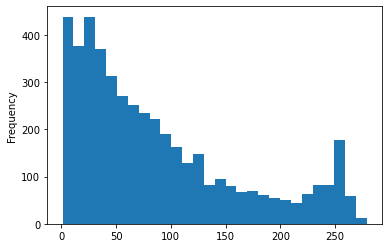

In [27]:
train['len_text'] = train['text'].apply(lambda x: len(x))
train['len_text'].plot(kind='hist', bins=28);

In [28]:
train.groupby('n_labels')['len_text'].agg(['median', 'mean'])

,median,mean
n_labels,,
1,40.0,60.938579
2,103.0,122.507246
3,159.5,165.370056
4,231.0,201.202381


Видно, что есть линейная зависимость между количеством меток и длиной отзыва

Далее проанализируем связку столбца assessment с метками

In [29]:
train.groupby('marked_labels_str')['assessment'].agg(['count', 'mean']).sort_values('count', ascending=False).head(30).sort_values('mean', ascending=False)

,count,mean
marked_labels_str,,
'Маленький ассортимент',127,4.582677
'Спасибо',212,4.500000
'Всё нормально',109,4.330275
"'Высокие цены', 'Маленький ассортимент'",50,4.320000
'Высокие цены',244,4.311475
'Товары с подходящим сроком годности',44,4.090909
"'Высокие цены', 'Качество товаров'",29,3.793103
'Высокая минимальная сумма заказа',61,3.770492
'Минимальная сумма заказа',59,3.762712


По вводным данным, assessment - это оценка пользователем сервиса.

Видно, что более суровые отзывы - с метками задержки и "все плохо" получают более низкие оценки. При этом нейтральные метки имеют среднюю оценку выше.

Далее - полезной фичей может оказаться скор токсичности отзыва. Для этого воспользуемся русскоязычным классификатором токсичности и проскорим трейн и тест

In [30]:
mark_dict = {0: '. Оценка 0',
            1: '. Оценка 1',
            2: '. Оценка 2',
            3: '. Оценка 3',
            4: '. Оценка 4',
            6: '. Оценка 6'}
train['text_mark'] = train.apply(lambda x: x['text'] + mark_dict[x['assessment']], axis=1)
test['text_mark'] = test.apply(lambda x: x['text'] + mark_dict[x['assessment']], axis=1)

In [31]:
train = train.sort_values('index')

Разобьем датасеты на обучающий и валидационный и сохраним

In [32]:
train_df, valid_df = train_test_split(train, random_state=42, stratify=train['n_labels'], test_size=0.1)
train_data = Dataset.from_pandas(train_df)
valid_data = Dataset.from_pandas(valid_df)
data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data

In [33]:
data.save_to_disk('data/train_valid_split_prepared')

In [34]:
pd.Series(trend_names).to_csv('data/trend_names.csv', index=False)

In [35]:
test.to_csv('data/prepared_test.csv')

Обучающая и тестовая выборка содержат ряд одинаковых текстов. Сгруппируем их и выберем моду в качестве таргета.

Во время предсказания теста будем использовать эти значения как справочник.

In [36]:
common_texts = set(train['text'].tolist()) & set(test['text'].tolist())
train_in_test = train[train['text'].isin(common_texts)]
train_in_test = pd.DataFrame(train[train['text'].isin(common_texts)].groupby('text')['marked_labels'].agg(lambda x:x.value_counts().index[0]))
train_in_test['id_labels'] = train_in_test['marked_labels'].apply(lambda x: [lab2id[l] for l in x])

In [37]:
train_in_test.to_csv('data/train_common.csv')

**Примечания**:

За кадром осталась такая работа с текстом, как:
- заполнение масок [NUM] при помощи Mistral-Large;
- генерация новых данных по 20-30 примеров на класс при помощи Mistral Large;
- добавление тегов в текст отзыва.

Все эти приемы не привели к улучшению качества на тестовой выборке

In [38]:
# !pip freeze >> requirements.txt